<a href="https://colab.research.google.com/github/1999Swarup/eyenet-cataract/blob/main/aieye.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Importing Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive',force_remount=False)

Mounted at /content/gdrive


#Importing Needed Libraries

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import pickle
import glob
from PIL import Image
import PIL
import PIL.Image
import seaborn as sns
from PIL import Image, ImageEnhance
import tensorflow as tf
from tensorflow.python.keras import regularizers
from tensorflow import keras
np.random.seed(42)
from sklearn.model_selection import train_test_split
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils import resample
from keras.utils.np_utils import to_categorical
import cv2
from tensorflow.keras import layers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

#Pre-processing

In [4]:
imagelist = []
grey0=[]
for filename in glob.glob('/content/gdrive/MyDrive/eyedata/1_normal/*.png'): 
    src = cv2.resize(cv2.imread(filename, 1),(128,128))
    tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY) #converting image to grayscale
    _,alpha = cv2.threshold(tmp,5,255,cv2.THRESH_BINARY)#alpha is the threshold value defining opacity between 5 to 255
    #If pixel value is not between 5 and 255 its considered as noise and any pixel value less than 5(min) is made 5(min) and same for 255(max). 
    b, g, r = cv2.split(src)
    rgba = [b,g,r,alpha]
    dst = cv2.merge(rgba,4)
    imagelist.append(dst)
    grey0.append(tmp)

In [5]:
df_n=pd.DataFrame()
df_n['images']=imagelist
df_n['labels']=0
df_n.head()

,images,labels
0,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",0
1,"[[[1, 1, 2, 0], [1, 1, 1, 0], [1, 0, 1, 0], [1...",0
2,"[[[1, 1, 1, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",0
3,"[[[0, 1, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",0
4,"[[[0, 0, 0, 0], [0, 1, 0, 0], [0, 0, 0, 0], [0...",0


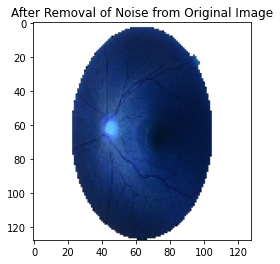

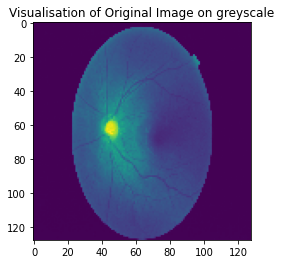

In [6]:
def visualize(original_image):
    fig=plt.figure()
    plt.subplot(1,1,1)
    plt.title('After Removal of Noise from Original Image')
    plt.imshow(original_image)

def visualizegrey(original_image):
    fig=plt.figure()
    plt.subplot(1,1,1)
    plt.title('Visualisation of Original Image on greyscale')
    plt.imshow(original_image)   


visualize(imagelist[0])
visualizegrey(grey0[0])

In [7]:
imagelist1 = []
grey1=[]
for filename in glob.glob('/content/gdrive/MyDrive/eyedata/2_cataract/*.png'): 
    src = cv2.resize(cv2.imread(filename, 1),(128,128))
    tmp = cv2.cvtColor(src, cv2.COLOR_BGR2GRAY)
    _,alpha = cv2.threshold(tmp,5,255,cv2.THRESH_BINARY)
    b, g, r = cv2.split(src)
    rgba = [b,g,r, alpha]
    dst = cv2.merge(rgba,4)
    imagelist1.append(dst)
    grey1.append(tmp)

In [8]:
df_cat=pd.DataFrame()
df_cat['images']=imagelist1
df_cat['labels']=1
df_cat.head()

,images,labels
0,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",1
1,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",1
2,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",1
3,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",1
4,"[[[0, 0, 0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0...",1


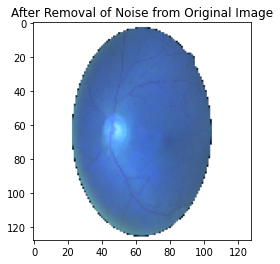

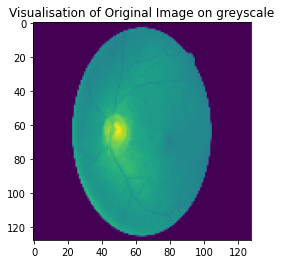

In [9]:
visualize(imagelist1[0])
visualizegrey(grey1[0])

#Splitting the Dataset


In [10]:
df_cat_train=df_cat.sample(frac =0.6)
df_cat_other = df_cat.drop(df_cat_train.index)

df_n_train=df_n.sample(frac = 0.6)
df_n_other = df_n.drop(df_n_train.index)

df_val_cat=df_cat_other.sample(frac =0.5)
df_val_n=df_n_other.sample(frac =0.5)

df_test_cat=df_cat_other.drop(df_val_cat.index)
df_test_n = df_n_other.drop(df_val_n.index)

#Resampling to balance the train dataset

In [11]:
n_samples=4000
df_train_n0_balanced = resample(df_n_train, replace=True, n_samples=n_samples, random_state=42) 
df_train_cat1_balanced = resample(df_cat_train, replace=True, n_samples=n_samples, random_state=42) 
#the validation data is not made to balance as it should represent the original imbalanced data that the model will face in testing

#Using the balanced dataset

In [12]:
train_eye_df_balanced = pd.concat([df_train_n0_balanced, df_train_cat1_balanced])
val_eye_df_balanced = pd.concat([df_val_n, df_val_cat])
test_eye_df_balanced = pd.concat([df_test_n, df_test_cat])

In [13]:
X_train = np.asarray(train_eye_df_balanced['images'].tolist())
X_train = X_train/255
Y=train_eye_df_balanced['labels']  #Assign label values to Y
y_train = to_categorical(Y, num_classes=2) #Convert to categorical as this is a multiclass(binary) classification problem

In [14]:
X_val = np.asarray(val_eye_df_balanced['images'].tolist())
X_val = X_val/255
Y=val_eye_df_balanced['labels']  #Assign label values to Y
y_val = to_categorical(Y, num_classes=2) #Convert to categorical as this is a multiclass(binary) classification problem

In [15]:
X_test = np.asarray(test_eye_df_balanced['images'].tolist())
X_test = X_test/255
Y_test=test_eye_df_balanced['labels']  #Assign label values to Y_test
y_test = to_categorical(Y_test, num_classes=2) #Convert to categorical as this is a multiclass(binary) classification problem

#Building the Model

In [24]:
model = tf.keras.Sequential()
model.add(Conv2D(16, (3, 3),kernel_regularizer=regularizers.l2(0.001), activation="relu", input_shape=(128, 128, 4)))
model.add(MaxPool2D(pool_size=(2, 2)))  

model.add(Conv2D(32, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3), kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(2, activation='softmax'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 126, 126, 16)      592       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 30, 30, 32)        0         
                                                                 
 conv2d_5 (Conv2D)           (None, 28, 28, 64)       

Since images are non-linear, to bring non-linearity, the relu activation function is applied after the convolutional operation.

Relu stands for Rectified linear activation function. Relu function will output the input directly if it is positive, otherwise it will output zero.

Here we have a 2 x 2 max-pool kernel. It selects the maximum value from a 2x2 patch. 

l2 regularization is used here after seeing that my model was overfitting. 

L2 reduces the magnitudes of the coefficients that help to decrease the complexity of the model.  

If there is noise present in the training data, then the estimated coefficients won’t generalize well and are not able to predict the future data.

This is where regularization comes into the picture, which shrinks or regularizes these learned estimates towards zero.

By noise we mean those data points in the dataset which don’t really represent the true properties of your data, but only due to a random chance.

#Compiling the Model

In [25]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['acc'])

Adam is a replacement optimization algorithm for stochastic gradient descent for training deep learning models.

Adam combines the best properties of the AdaGrad and RMSProp algorithms to provide an optimization algorithm that can handle sparse gradients on noisy problems.

In [26]:
from keras.callbacks import ModelCheckpoint
model_chk=ModelCheckpoint(filepath='/content/gdrive/MyDrive/eyedata/eyeModel1.hdf5', monitor='val_loss', save_best_only=True)

#Model Fitting

In [27]:
batch_size = 64
epochs = 20

hist = model.fit(
    X_train, y_train,
    epochs=epochs,
    batch_size = batch_size,
    validation_data=(X_val, y_val),
    callbacks=model_chk,
    verbose=2)

score = model.evaluate(X_test, y_test)
print('Test accuracy:', score[1])

Epoch 1/20
125/125 - 5s - loss: 0.6097 - acc: 0.6895 - val_loss: 0.5161 - val_acc: 0.7375 - 5s/epoch - 40ms/step
Epoch 2/20
125/125 - 3s - loss: 0.4200 - acc: 0.8225 - val_loss: 0.3388 - val_acc: 0.8750 - 3s/epoch - 22ms/step
Epoch 3/20
125/125 - 3s - loss: 0.3364 - acc: 0.8715 - val_loss: 0.3977 - val_acc: 0.8250 - 3s/epoch - 21ms/step
Epoch 4/20
125/125 - 3s - loss: 0.2755 - acc: 0.9043 - val_loss: 0.3717 - val_acc: 0.8625 - 3s/epoch - 21ms/step
Epoch 5/20
125/125 - 3s - loss: 0.2131 - acc: 0.9384 - val_loss: 0.2574 - val_acc: 0.9375 - 3s/epoch - 22ms/step
Epoch 6/20
125/125 - 3s - loss: 0.1832 - acc: 0.9521 - val_loss: 0.3265 - val_acc: 0.8625 - 3s/epoch - 22ms/step
Epoch 7/20
125/125 - 3s - loss: 0.1580 - acc: 0.9638 - val_loss: 0.3014 - val_acc: 0.9250 - 3s/epoch - 22ms/step
Epoch 8/20
125/125 - 3s - loss: 0.1441 - acc: 0.9688 - val_loss: 0.3342 - val_acc: 0.9000 - 3s/epoch - 21ms/step
Epoch 9/20
125/125 - 3s - loss: 0.1218 - acc: 0.9783 - val_loss: 0.3779 - val_acc: 0.8500 - 3s/e

#Evaluation of the Model

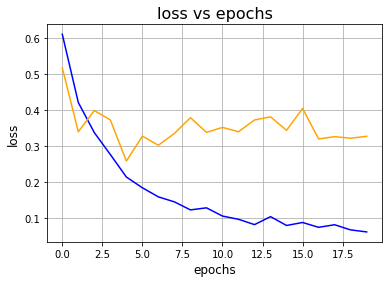

In [28]:
plt.plot(hist.history['loss'], color='blue', label='train')
plt.plot(hist.history['val_loss'], color='orange', label='train')
plt.grid(True)
plt.title("loss vs epochs", fontsize=16)
plt.xlabel("epochs",fontsize=12)
plt.ylabel("loss", fontsize=12)
plt.show()

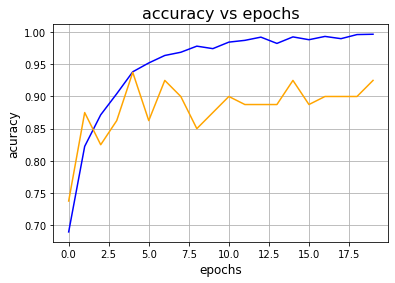

In [29]:
plt.plot(hist.history['acc'], color='blue', label='train')
plt.plot(hist.history['val_acc'], color='orange', label='train')
plt.grid(True)
plt.title("accuracy vs epochs", fontsize=16)
plt.xlabel("epochs",fontsize=12)
plt.ylabel("acuracy", fontsize=12)
plt.show()

In [30]:
from sklearn.metrics import classification_report
ynew = np.argmax(model.predict(X_test), axis=-1)
test_labels=np.argmax(y_test, axis=1)
# classification report for precision, recall, f1-score and accuracy
matrix = classification_report(test_labels,ynew,labels=[1,0])
print('Classification report : \n',matrix)

Classification report : 
               precision    recall  f1-score   support

           1       0.90      0.90      0.90        20
           0       0.97      0.97      0.97        60

    accuracy                           0.95        80
   macro avg       0.93      0.93      0.93        80
weighted avg       0.95      0.95      0.95        80



True Positive: We predicted positive and it’s true. In the image, we predicted that a woman is pregnant and she actually is.

True Negative: We predicted negative and it’s true. In the image, we predicted that a man is not pregnant and he actually is not.

False Positive (Type 1 Error)- We predicted positive and it’s false. In the image, we predicted that a man is pregnant but he actually is not.

False Negative (Type 2 Error)- We predicted negative and it’s false. In the image, we predicted that a woman is not pregnant but she actually is.

We discussed Accuracy, now let’s discuss some other metrics of the confusion matrix

1. Precision —Precision explains how many of the correctly predicted cases actually turned out to be positive. Precision is useful in the cases where False Positive is a higher concern than False Negatives.
Precision for a label is defined as the number of true positives divided by the number of predicted positives.

Evaluation Metrics For Classification Model precision
2. Recall (Sensitivity) — Recall explains how many of the actual positive cases we were able to predict correctly with our model. It is a useful metric in cases where False Negative is of higher concern than False Positive. It is important in medical cases where it doesn’t matter whether we raise a false alarm but the actual positive cases should not go undetected!

Recall for a label is defined as the number of true positives divided by the total number of actual positives.

recall Evaluation Metrics For Classification Model
3. F1 Score — It gives a combined idea about Precision and Recall metrics. It is maximum when Precision is equal to Recall.

F1 Score is the harmonic mean of precision and recall.

F1 Score
The F1 score punishes extreme values more. F1 Score could be an effective evaluation metric in the following cases:

When FP and FN are equally costly.
Adding more data doesn’t effectively change the outcome
True Negative is high

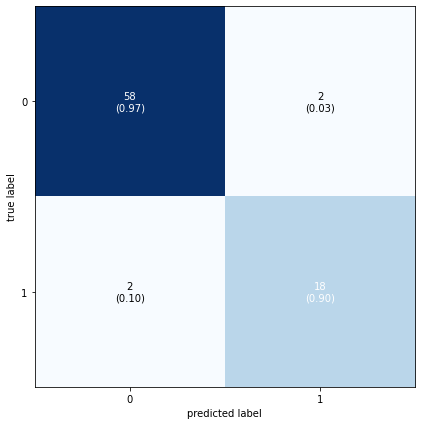

In [31]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from mlxtend.plotting import plot_confusion_matrix
cm = confusion_matrix(test_labels,ynew)
plot_confusion_matrix(conf_mat = cm,figsize=(8,7),
                      show_normed = True);